In [243]:
import copy as cp
import itertools
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from photonic_circuit_solver import *
import time

class RingState:
    """
    Class for working with and storing information about an n node ring state
    """

    def __init__(self, nodes:int):
        """
        Initializes class

        Parameters:
        - nodes : Number of nodes the graph state contains
        """
        self.nodes = nodes
        self.orderings = list()
        self.data = list()
    
    def __getitem__(self, index:int):
        """
        Returns ordering at index

        Parameters:
        - index : Index of desired ordering from list of unique orderings
        """
        return self.orderings[index] if self.orderings else None
    
    def get_orderings(self):
        """
        
        """
        time_start = time.time()

        permutations = [list(perm) for perm in itertools.permutations(range(self.nodes)[1:], self.nodes - 1)]
        for permutation in permutations:
            if permutation[0] == self.nodes-1:
                break
            elif permutation[0] > permutation[-1]:
                pass
            else:
                permutation.insert(0, 0)
                ordering = []
                for i in range(self.nodes):
                    edge = [permutation[i], permutation[i+1]] if i != self.nodes-1 else [permutation[i], permutation[0]] 
                    ordering.append(edge)
                self.orderings.append(ordering)
        
        print("Time taken :", round((time.time()-time_start) * 1000, 3), "ms")
    
    def get_lowest(self, max=None):
        time_start = time.time()

        max = len(self.orderings) if max == None else max
        index = 0
        for ordering in self.orderings[0:max]:
            qc = qiskit_circuit_solver(Stabilizer(edgelist=ordering))
            qcd = dict(qc.count_ops())
            num_cnot = qcd.get('cx')
            num_hadamard = qcd.get('h')
            depth = qc.depth()
            emitters = qc.num_qubits - self.nodes
            if index == 0:
                l_index = index
            else:
                cnot_check = num_cnot < self.data[l_index][1]
                hadamard_check = num_cnot == self.data[l_index][1] and num_hadamard < self.data[l_index][2]
                depth_check = num_cnot == self.data[l_index][1] and num_hadamard == self.data[l_index][2] and depth < self.data[l_index][4]

                if cnot_check or hadamard_check or depth_check:
                    print(l_index, index)
                    l_index = index
                
            ordering_data = [index, num_cnot, num_hadamard, emitters, depth]
            self.data.append(ordering_data)
            index += 1

        print("Time taken :", round((time.time()-time_start) * 1000, 3), "ms")

        return self.data[l_index]

    def plot_data(self, sort_by:int=0):
        def sort_key(listed):
            return listed[:][sort_by]
        plot_data = cp.deepcopy(self.data)
        plot_data.sort(key=sort_key)
        plot_data = np.array(plot_data)
        plt.plot(range(len(plot_data)), plot_data[:,1], label='# CNOT')
        plt.plot(range(len(plot_data)), plot_data[:,2], label='# Hadamard')
        plt.plot(range(len(plot_data)), plot_data[:,3], label='# Emitters')
        plt.plot(range(len(plot_data)), plot_data[:,4], label='Depth')
        plt.legend()
        plt.xlabel("Ordering Index")
        plt.ylabel("Value")
    
    def nx_plot(self, index:int):
        G = nx.Graph()
        G.add_nodes_from(range(self.nodes))
        G.add_edges_from(self.orderings[index])
        return G

rs = RingState(9)
rs.get_orderings()
lowest = rs.get_lowest(max=None)

Time taken : 111.678 ms
0 1
1 11
11 71
71 479
Time taken : 100462.868 ms


In [244]:
print(rs.data[1])
print(rs.data[11])
print(rs.data[71])
print(rs.data[479])

[1, 11, 13, 2, 22]
[11, 11, 13, 2, 20]
[71, 11, 13, 2, 18]
[479, 11, 13, 2, 17]


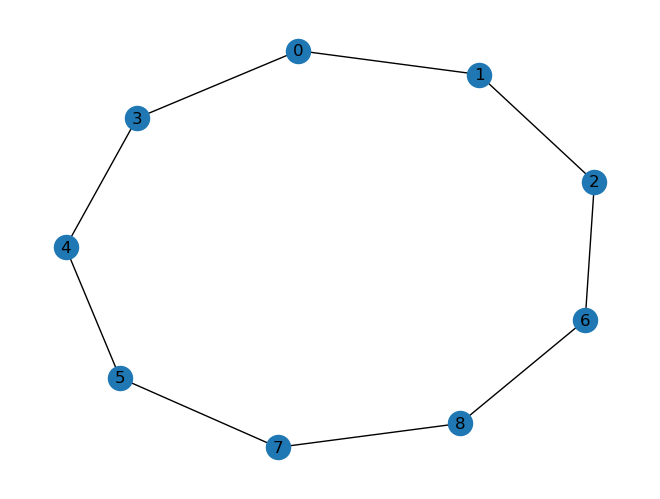

In [245]:
nx.draw(rs.nx_plot(lowest[0]), with_labels=True)

[479, 11, 13, 2, 17]
[[0, 1], [1, 2], [2, 6], [6, 8], [8, 7], [7, 5], [5, 4], [4, 3], [3, 0]]


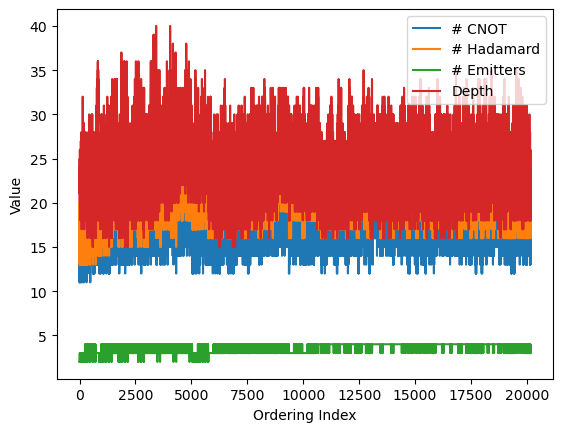

In [246]:
rs.plot_data(0)
print(rs.data[lowest[0]])
print(rs.orderings[lowest[0]])

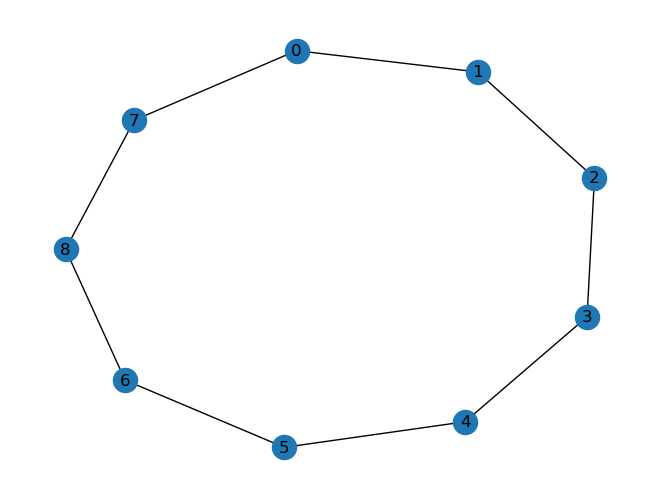

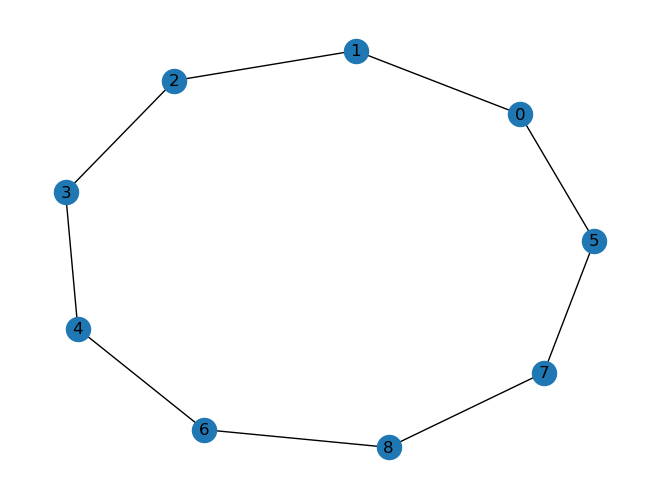

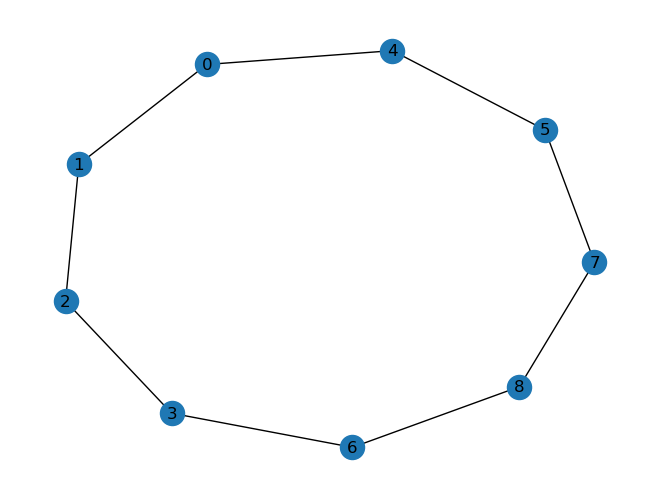

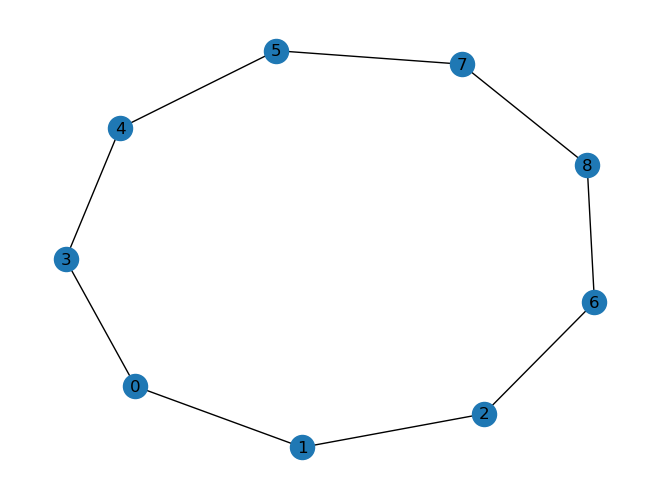

In [247]:
plt.figure(1)
nx.draw(rs.nx_plot(1), with_labels=True)
plt.figure(2)
nx.draw(rs.nx_plot(11), with_labels=True)
plt.figure(3)
nx.draw(rs.nx_plot(71), with_labels=True)
plt.figure(4)
nx.draw(rs.nx_plot(479), with_labels=True)